In [1]:
from utils import *
from models import *


import os
os.chdir('../..')
print(os.getcwd())

/Users/joyqiu/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


using device:  cpu
using device:  cpu
/Users/joyqiu/Documents/Documents JoyQiu Work/Research/LLMTimeSeries/llm_nicu_vitalsigns


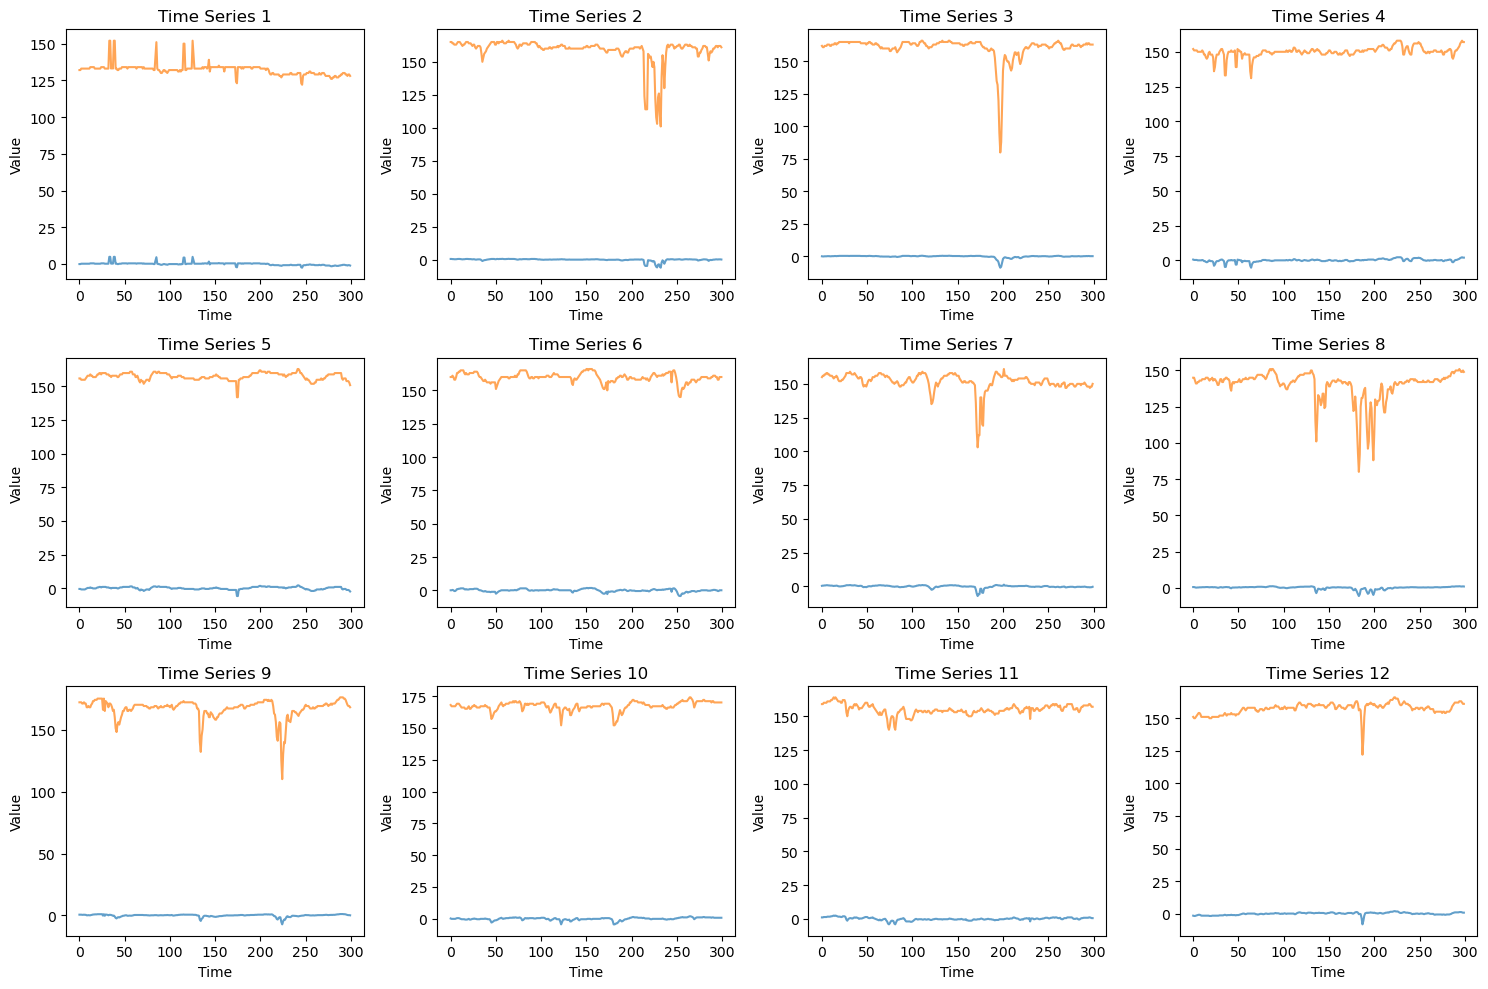

In [14]:
data_path = './data/PAS Challenge HR Data.xlsx'  
batch_size = 128
train_dataloader, test_dataloader, df_scaled, df = prepare_data(data_path, batch_size=batch_size)
dataset = VSTSDataset(df_scaled)

In [16]:
model_path = './script/VAE/results/hr_vae_linear_medium.pth' 
# Initialize model
model = VAE_Linear_Medium().to(device)
model.load_state_dict(torch.load(model_path))
model.eval()


VAE_Linear_Medium(
  (encoder): Sequential(
    (0): Linear(in_features=300, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Linear(in_features=256, out_features=128, bias=True)
    (9): LeakyReLU(negative_slope=0.2)
  )
  (mean_layer): Linear(in_features=128, out_features=32, bias=True)
  (logvar_layer): Linear(in_features=128, out_features=32, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=256, out_features=512, bias=True)
    (5): LeakyReLU(ne

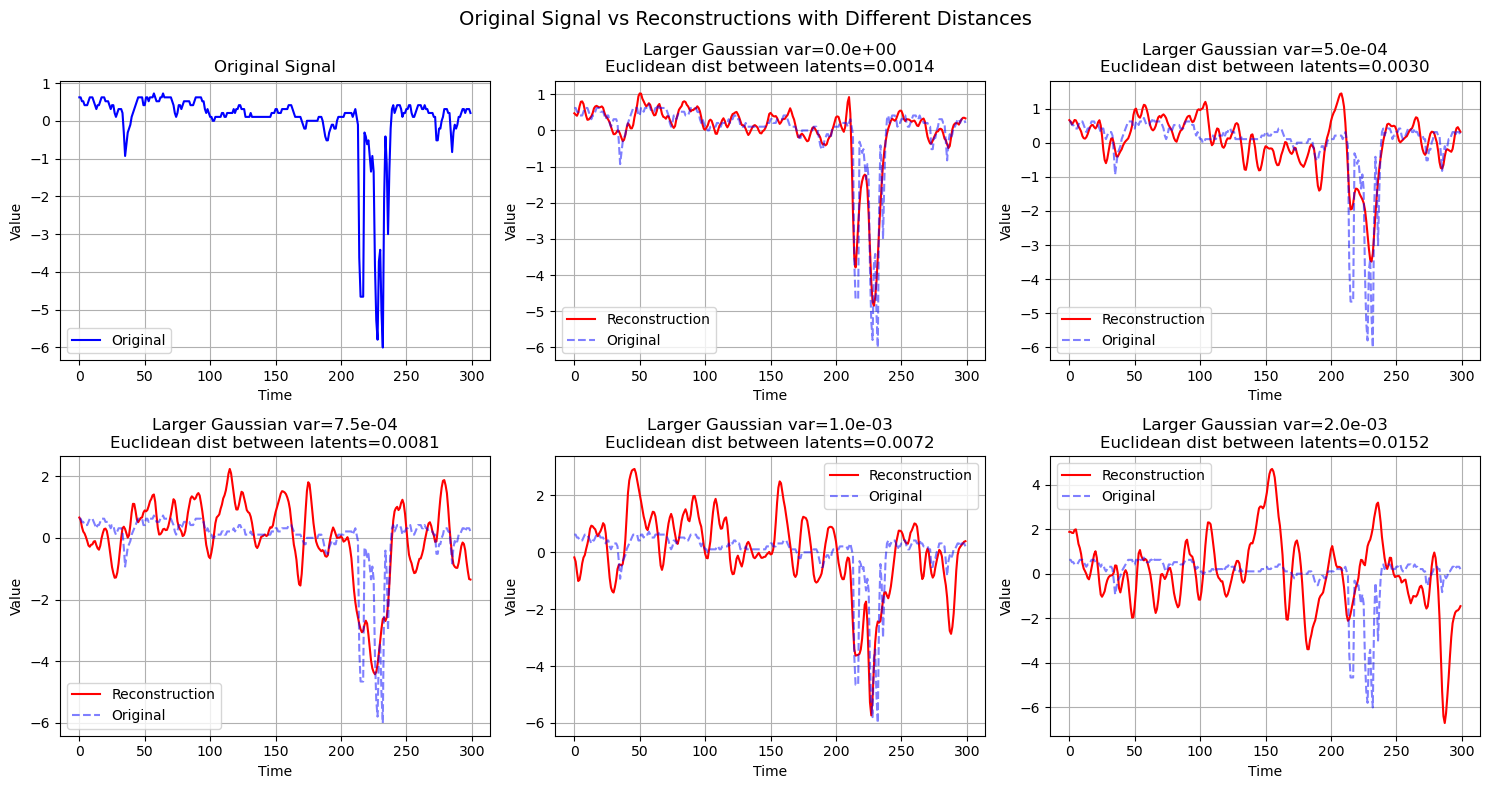

In [18]:
x = dataset[1]

# Create figure and subplots
fig, axs = plt.subplots(2, 3, figsize=(15, 8))
fig.suptitle('Original Signal vs Reconstructions with Different Distances', fontsize=14)

# Flatten axs for easier iteration
axs = axs.flatten()

# Plot original signal in first subplot
axs[0].plot(x.detach().numpy(), 'b-', label='Original')
axs[0].set_title('Original Signal')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Value')
axs[0].grid(True)
axs[0].legend()

# Plot reconstructions with different distances
distances = [0, 5e-4, 7.5e-4, 1e-3, 2e-3]
for i, distance in enumerate(distances, 1):
    # Get embeddings and reconstruction
    z_mean, z_log_var = model.encode(x)
    z = model.reparameterization(z_mean, z_log_var + distance)
    x_hat = model.decode(z)
    z_mean_hat, z_log_var_hat = model.encode(x_hat)

    # Calculate Euclidean distance
    z_mean = z_mean.cpu().detach().numpy()
    z_mean_hat = z_mean_hat.cpu().detach().numpy()
    euc_dist = np.sqrt(np.sum((z_mean - z_mean_hat) ** 2))

    # Plot reconstruction
    axs[i].plot(x_hat.detach().numpy(), 'r-', label=f'Reconstruction')
    axs[i].plot(x.detach().numpy(), 'b--', alpha=0.5, label='Original')
    axs[i].set_title(f'Larger Gaussian var={distance:.1e}\nEuclidean dist between latents={euc_dist:.4f}')
    axs[i].set_xlabel('Time')
    axs[i].set_ylabel('Value')
    axs[i].grid(True)
    axs[i].legend()

# Adjust layout
plt.tight_layout()
plt.show()

In [10]:
x.shape

torch.Size([300])